# EXPLORATORY DATA ANALYSIS (I.)

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 60)

In [2]:
KEYS = [
    'entity_id',
    'financial_report_id',
    'financial_statement_id',
    'entity_ico',
    'entity_name']

DIMENSIONS = [
    'year',
    # 'month',
    # 'financial_report_order_number',
    'period_length',
    # 'consolidated',
    # 'approved_date',
    'type',
    'financial_report_template_id',
    # 'establishment_date',
    # 'cancellation_date',
    # 'sknace_code',
    # 'entity_state',
    'legal_form_code',
    'org_size_code',
    'ownership_category_code',
    'entity_consolidated',
    # 'sknace_division_name',
    'sknace_division',
    'sknace_division_normalized',
    # 'sknace_subcategory',
    'sal_class',
    'is_mahalanobis_outlier',
    'is_isolation_forest_outlier']


RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]

DISTRESS_SIGNALS = [
    'DPHZ_vat_registration_cancelled',
    'DPHZ_vat_registration_cancelled_1y_off',
    'DPHZ_vat_registration_cancelled_2y_off',
    'DPHZ_vat_registration_cancelled_3y_off',
    'RU_event',
    'RU_event_1y_off',
    'RU_event_2y_off',
    'RU_event_3y_off',
    'cancellation_year',
    'RUZ_cancelled',
    'RUZ_cancelled_1y_off',
    'RUZ_cancelled_2y_off',
    'RUZ_cancelled_3y_off']

In [3]:

training_raw = pd.read_csv('../../DATA/FINAL/training_sample.csv')
testing_raw = pd.read_csv('../../DATA/FINAL/testing_sample.csv')
data_raw = pd.read_csv('../../DATA/FINAL/super_sample.csv')


def winsorize(x, lower_bound, upper_bound):
    if x != x: return x
    if x < lower_bound: return lower_bound
    if x > upper_bound: return upper_bound
    return x

    
thresholds_skew = dict()
thresholds_sym = dict()

training_capped = training_raw.copy()
testing_capped = testing_raw.copy()
data_capped = data_raw.copy()

for col in RATIOS:
    if data_capped[col].min() >= 0:
        threshold_min = 0
        threshold_max = training_raw[col].quantile(0.95)
    else:
        threshold_min = training_raw[col].quantile(0.025)
        threshold_max = training_raw[col].quantile(0.975)

    training_capped[col] = training_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))
    testing_capped[col] = testing_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))
    data_capped[col] = data_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))

summary_non_capped = testing_raw[RATIOS].describe().T.reset_index().rename(columns={'index': 'ratio'}).reset_index()
summary_capped = testing_capped[RATIOS].describe().T.reset_index().rename(columns={'index': 'ratio'}).reset_index()

summary_non_capped['skew'] = list(testing_raw[RATIOS].skew())
summary_capped['skew'] = list(testing_capped[RATIOS].skew())

summary_non_capped['type'] = 'raw'
summary_capped['type'] = 'winsorized'

pd.concat([summary_non_capped, summary_capped], axis=0).sort_values(['index', 'type'])

training_capped.to_csv('../../DATA/FINAL/winsorized/training_sample.csv', index = False)
testing_capped.to_csv('../../DATA/FINAL/winsorized/testing_sample.csv', index = False)
data_capped.to_csv('../../DATA/FINAL/winsorized/super_sample.csv', index = False)

In [4]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [5]:
mean_values = dict()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        subset_training = training_capped.query('sal_class == @sal_class and sknace_division == @sknace')
        segment_mean_values = dict()
        for col in RATIOS:
            mean_value = subset_training[col].mean()
            # if np.isnan(mean_value): print(sal_class, sknace, col)
            segment_mean_values[col] = mean_value
        
        mean_values[(sal_class, sknace)] = segment_mean_values
    


In [6]:
data_filled = pd.DataFrame()
training_filled = pd.DataFrame()
testing_filled = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        subset_data = data_capped.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        subset_training = training_capped.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        subset_testing = testing_capped.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        segment_mean_values = mean_values[(sal_class, sknace)]

        for col in RATIOS:
            mean_value = segment_mean_values[col]
            subset_data[col] = subset_data[col].fillna(mean_value).fillna(0)
            subset_training[col] = subset_training[col].fillna(mean_value).fillna(0)
            subset_testing[col] = subset_testing[col].fillna(mean_value).fillna(0)

        data_filled = pd.concat([data_filled, subset_data], axis = 0)
        training_filled = pd.concat([training_filled, subset_training], axis = 0)
        testing_filled = pd.concat([testing_filled, subset_testing], axis = 0)

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_11604\1245056479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data[col] = subset_data[col].fillna(mean_value).fillna(0)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_11604\1245056479.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_training[col] = subset_training[col].fillna(mean_value).fillna(0)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_11604\1245056479.py:16: SettingWithCopyWarning: 
A value is trying to be set on a co

In [7]:
training_filled.to_csv('../../DATA/FINAL/filled/training_sample.csv', index = False)
testing_filled.to_csv('../../DATA/FINAL/filled/testing_sample.csv', index = False)
data_filled.to_csv('../../DATA/FINAL/filled/super_sample.csv', index = False)

In [8]:
def one_hot_encode(df, categorical_columns):
    for col in categorical_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")

    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
    
    return df_encoded

training_filled['sknace'] = training_filled['sknace_division_normalized'].copy()
testing_filled['sknace'] = testing_filled['sknace_division_normalized'].copy()
data_filled['sknace'] = data_filled['sknace_division_normalized'].copy()

training_filled = one_hot_encode(training_filled, ['sknace'])
testing_filled = one_hot_encode(testing_filled, ['sknace'])
data_filled = one_hot_encode(data_filled, ['sknace'])

training_filled.to_csv('../../DATA/FINAL/final/training_sample.csv', index = False)
testing_filled.to_csv('../../DATA/FINAL/final/testing_sample.csv', index = False)
data_filled.to_csv('../../DATA/FINAL/final/super_sample.csv', index = False)

In [9]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0).reset_index()
    return wide_df

In [10]:
def get_counts_by(data, dim, label = None):

    data2 = data.copy()
    data2[dim] = 'Spolu'
    data['priority'] = 1
    data2['priority'] = 2
    data = pd.concat([data, data2], axis=0)

    total = data.groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('total')
    combined = data.query('combined_issue_criteria_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('combined')
    indirect = data.query('RUZ_indirect_criteria_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('indirect')
    cancelled = data.query('RUZ_cancelled_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('cancelled')
    insolvency = data.query('RU_event_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('insolvency')

    summary = (pd.concat(
        [
            total,
            combined,
            indirect,
            cancelled,
            insolvency
        ], axis = 1
    ).reset_index().sort_values(by=['priority', 'total'], ascending=[True, False]))

    summary['combined_p'] = (summary['combined'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['indirect_p'] = (summary['indirect'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['cancelled_p'] = (summary['cancelled'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['insolvency_p'] = (summary['insolvency'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')

    if label is None: label = dim

    col_rename = {
        dim : label,
        'total' : 'Celkový počet',
        'combined_p' : 'Kombinované kritérium',
        'indirect_p' : 'Nepriame kritérium',
        'cancelled_p' : 'Zaniknutá spoločnosť',
        'insolvency_p' : 'Insolvenčné konanie'
    }

    display(summary[[dim, 'total', 'combined_p', 'indirect_p', 'cancelled_p', 'insolvency_p']].rename(columns=col_rename))
    
    print(summary[[dim, 'total', 'combined_p', 'indirect_p', 'cancelled_p', 'insolvency_p']].rename(columns=col_rename).to_latex(index=False))
    

get_counts_by(data_raw, 'sal_class', label = 'SK NACE')

,SK NACE,Celkový počet,Kombinované kritérium,Nepriame kritérium,Zaniknutá spoločnosť,Insolvenčné konanie
0,2. Malý,7331,10.0%,7.7%,1.1%,2.5%
1,3. Stredný,1654,8.5%,6.1%,1.1%,2.7%
2,Spolu,8985,9.7%,7.4%,1.1%,2.6%


\begin{tabular}{lrllll}
\toprule
   SK NACE &  Celkový počet & Kombinované kritérium & Nepriame kritérium & Zaniknutá spoločnosť & Insolvenčné konanie \\
\midrule
   2. Malý &           7331 &                 10.0\% &               7.7\% &                 1.1\% &                2.5\% \\
3. Stredný &           1654 &                  8.5\% &               6.1\% &                 1.1\% &                2.7\% \\
     Spolu &           8985 &                  9.7\% &               7.4\% &                 1.1\% &                2.6\% \\
\bottomrule
\end{tabular}



In [11]:
# print(1)
# display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'is_isolation_forest_outlier'))

# display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'combined_issue_criteria_3y_off'))
# display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'RUZ_indirect_criteria_3y_off'))
# display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'RUZ_cancelled_3y_off'))
# display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'RU_event_3y_off'))

# display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'combined_issue_criteria_3y_off'))
# display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'RUZ_indirect_criteria_3y_off'))
# display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'RUZ_cancelled_3y_off'))
# display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'RU_event_3y_off'))

## 1. Struktura udajov z pohladu velkostnej kategorie, oblasti zamerania etc.

In [12]:
display(data_capped.info())
display(data_capped[RATIOS].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8985 entries, 0 to 8984
Columns: 101 entries, entity_id to is_isolation_forest_outlier
dtypes: bool(3), float64(79), int64(9), object(10)
memory usage: 6.7+ MB


None

,L1,L2,L3,NCL_CF,CASH_TA,INV_COGS,CC_SAL,TL_COST,CL_COST,SAL_TA,EQ_TA,EQ_TL,CL_CC,LTC_NCA,TZ,CF_TL,CL_TA,NCL_TA,EBT_REV,ROS,EAT_REV,ROA,ROE,CF_TA,CF_SAL,LABOR_EAT,LABOR_REV
count,8983.000000,8983.000000,8983.000000,8984.000000,8985.000000,6389.000000,8957.000000,8983.000000,8983.000000,8985.000000,8985.000000,8985.000000,8966.000000,8834.000000,8984.000000,8984.000000,8985.000000,8985.000000,8985.000000,8957.000000,8985.000000,8985.000000,8985.000000,8985.000000,8957.000000,8982.000000,8985.000000
mean,0.525146,1.789133,2.326443,0.900011,0.129443,7.814076,0.210952,0.520146,0.269441,2.345871,0.351461,0.357468,2.020298,9.373802,0.469651,0.396584,0.424008,0.069673,0.056001,0.044978,0.043351,0.077766,0.193104,0.147112,0.096454,8.478387,0.118361
std,0.826255,1.733222,2.097700,2.358469,0.154881,22.412770,0.189032,0.606220,0.238925,1.674253,0.268637,0.271126,2.397137,25.432218,6.882545,0.640200,0.261479,0.122441,0.095433,0.084988,0.078702,0.120515,0.413282,0.152043,0.123977,22.780796,0.123895
min,0.000000,0.000361,0.000361,-1.006790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.164890,-0.165510,0.000000,0.069719,-18.749789,-0.122761,0.000000,0.000000,-0.102021,-0.108240,-0.098736,-0.134910,-1.217556,-0.081707,-0.051982,-18.098649,0.000000
25%,0.037059,0.723741,1.057723,0.004564,0.013006,0.041743,0.086091,0.178867,0.113884,1.134381,0.136868,0.140829,0.692731,1.051080,-1.790588,0.067853,0.207104,0.001140,0.006219,0.004197,0.004143,0.008155,0.027315,0.048180,0.021985,0.164760,0.027169
50%,0.168512,1.188386,1.534738,0.068235,0.061664,0.211649,0.155895,0.305748,0.191979,1.949470,0.313088,0.319329,1.130021,1.784400,-0.289261,0.175919,0.390877,0.010744,0.027113,0.021117,0.020854,0.042736,0.148808,0.107789,0.056914,1.755733,0.080050
75%,0.577458,2.108252,2.687773,0.574854,0.189765,1.339976,0.262252,0.557111,0.326352,3.154883,0.545386,0.554296,2.098504,4.494160,2.151469,0.418369,0.621099,0.068351,0.075409,0.060187,0.059216,0.114525,0.382251,0.200416,0.124109,6.498147,0.164719
max,3.212989,7.135926,8.763377,12.081125,0.533638,94.924400,0.772572,2.589372,0.985065,6.599492,0.910062,0.914643,9.916796,138.017947,24.924097,3.229242,0.923162,0.448514,0.416971,0.380309,0.339143,0.491577,1.017821,0.660174,0.581879,115.808817,0.521865


## 2. Analýza distribúcie prediktorov

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson

def plot_histograms(df, columns, apply_yeojohnson_transform=False):
    # Plotting the histograms
    fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        data = df.query(f'{column} == {column} and {column} != 0')[column]

        # Calculate initial skewness
        data_skewness = round(data.skew(), 1)

        # Apply Yeo-Johnson transformation if requested
        if apply_yeojohnson_transform:
            data, _ = yeojohnson(data)  # The function returns a tuple of transformed data and lambda
            transformation = 'Yeo-Johnson Transformed'
        else:
            transformation = 'Original'

        # Calculate skewness after transformation
        data_skewness_new = round(pd.Series(data).skew(), 1)  # Ensure data is a Series for skew method
        
        Q1 = np.quantile(data, 0.25)
        Q2 = np.quantile(data, 0.5)
        Q3 = np.quantile(data, 0.75)
        
        IQR = Q3 - Q1

        bin_width = 2 * IQR / (len(data) ** (1/3))
        num_bins = min(100, int(np.ceil((np.max(data) - np.min(data)) / bin_width)))

        sns.histplot(data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
        ax.set_title(f'{column}, {transformation}, original skewness: {data_skewness}, transformed skewness: {data_skewness_new}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        # Calculate bounds for displaying z-score thresholds
        mean = np.mean(data)
        std = np.std(data)
        for color, z_score_threshold in [('red', 3), ('blue', 2)]:
            lower_bound = mean - z_score_threshold * std
            upper_bound = mean + z_score_threshold * std
            ax.axvline(lower_bound, color=color, linewidth=1, label=f'Lower Bound, Threshold {z_score_threshold}')
            ax.axvline(upper_bound, color=color, linestyle='--', linewidth=1, label=f'Upper Bound, Threshold {z_score_threshold}')

        # Add vertical line for median
        ax.axvline(Q2, color='green', linestyle='-', linewidth=2, label='Median')

        # Only add legend to the first plot for clarity
        if i == 0:
            ax.legend()

    # Hide empty subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

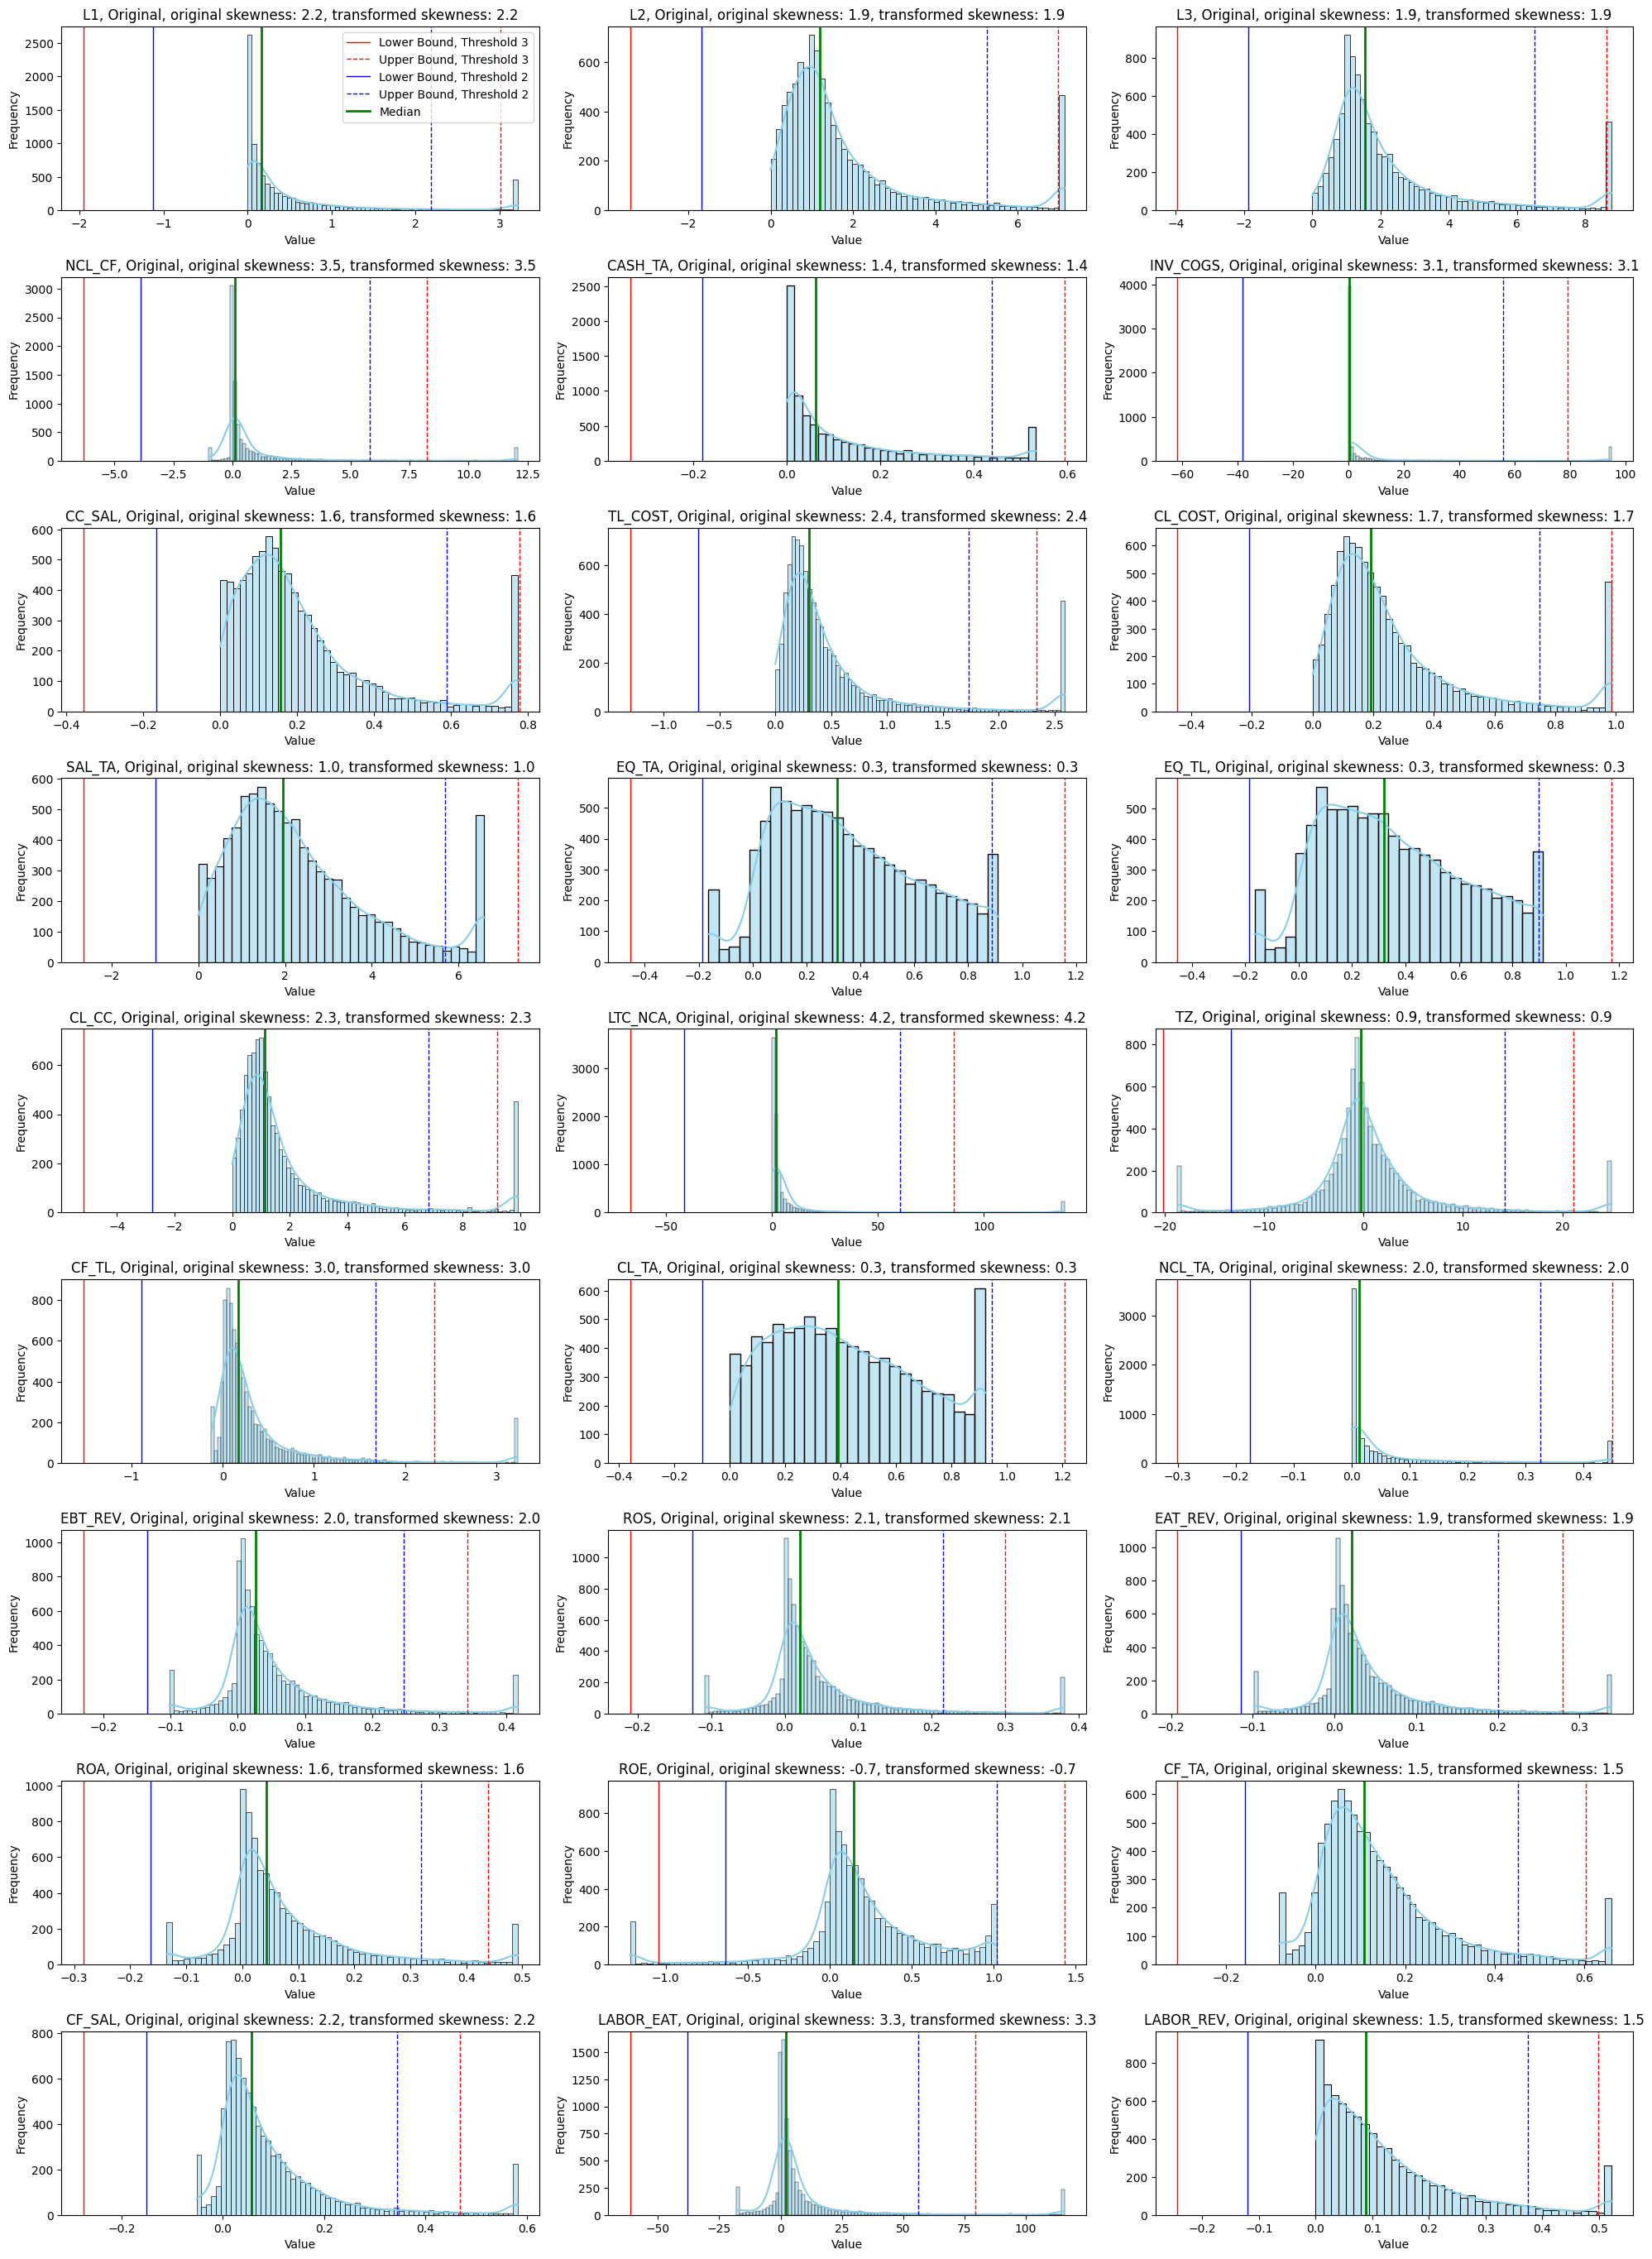

In [14]:
plot_histograms(data_capped, RATIOS, False)

## 2. Analýza multikolinearity

In [15]:
Q = data_filled.query('combined_issue_criteria_3y_off == 1').shape[0]
subset = pd.concat(
    [
        data_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        data_filled.query('combined_issue_criteria_3y_off == 0').sample(Q)
    ], axis = 0
)

In [17]:
# correlated_features = [ 'EAT_REV', 'EQ_TL', 'CF_SAL', 'L2', 'CF_TA']
correlated_features = [ 'EAT_REV', 'EQ_TL', 'CF_TA', 'EBT_REV', 'L2', 'CF_SAL', 'CL_COST']

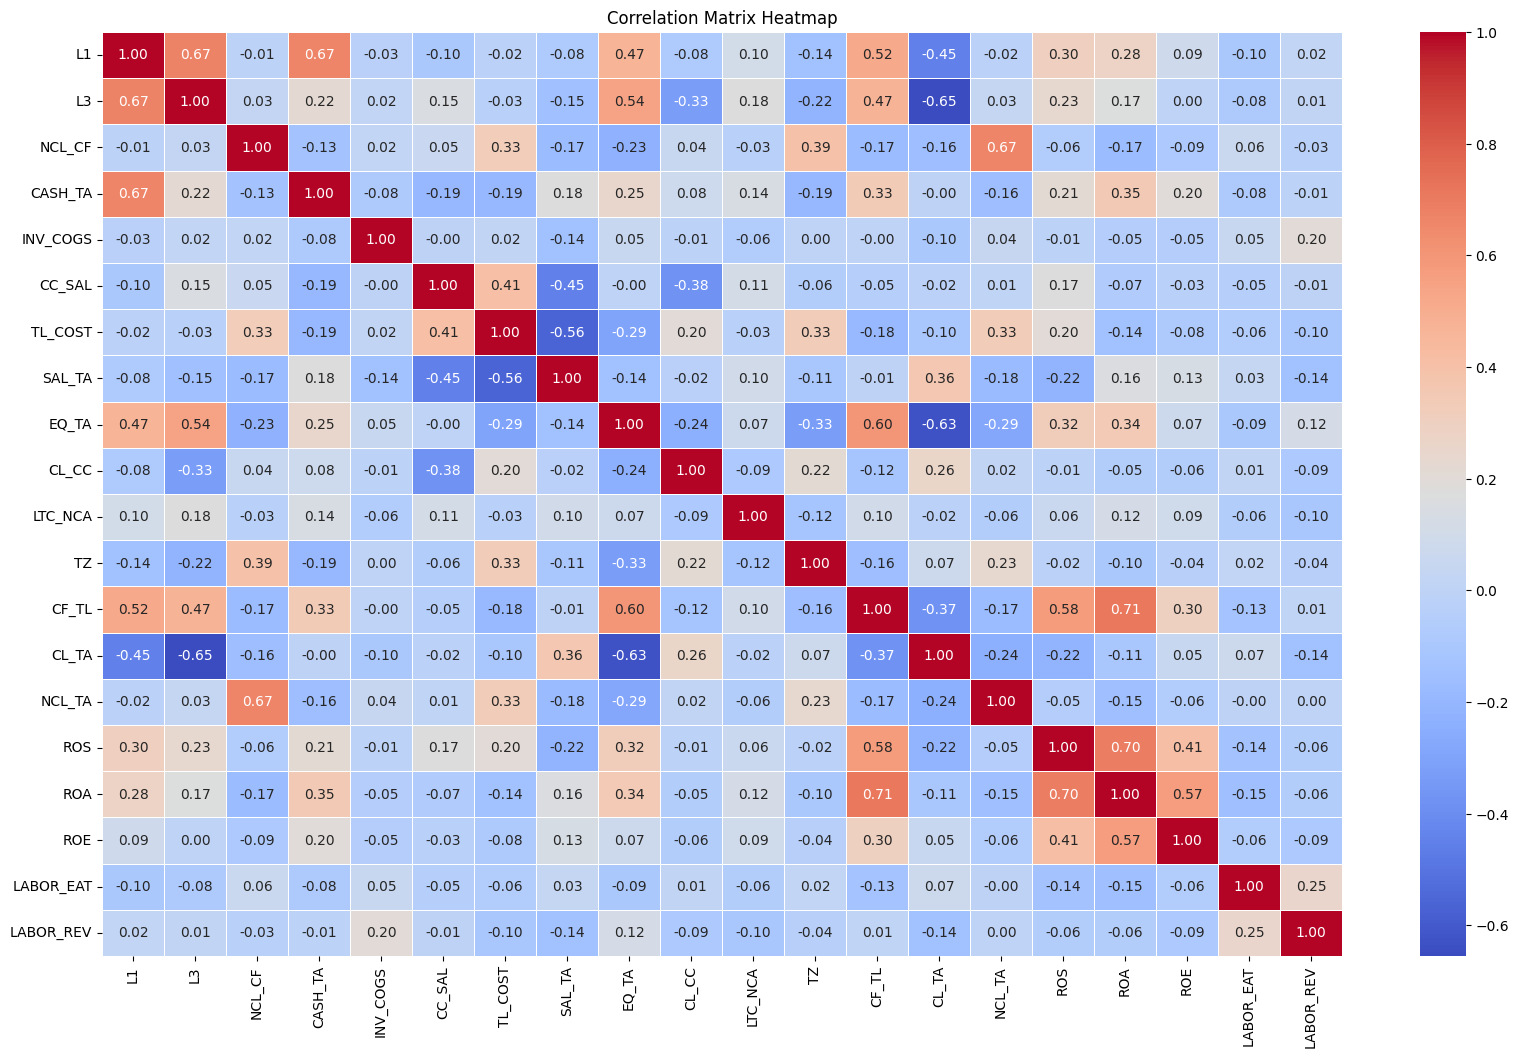

In [18]:
# Calculate the correlation matrix
correlation_matrix = data_filled[RATIOS].drop(columns=correlated_features).corr()

# display(correlation_matrix)
# Create a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = data_filled[RATIOS].copy().drop(columns=correlated_features + equal_pdf + equal_pdf_in_subgroups)
print(df.columns)
# Adding a constant for the intercept
df_const = add_constant(df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = df_const.columns
vif_data['VIF'] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]


print(vif_data.sort_values('VIF').to_latex(index = False))

Index(['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS',
       'ROA', 'ROE'],
      dtype='object')
\begin{tabular}{lr}
\toprule
feature &       VIF \\
\midrule
LTC\_NCA &  1.068019 \\
  CL\_CC &  1.223935 \\
     TZ &  1.226966 \\
    ROE &  1.562983 \\
    ROS &  2.081427 \\
     L1 &  2.105824 \\
  CL\_TA &  2.400441 \\
  EQ\_TA &  2.574743 \\
     L3 &  2.967443 \\
  CF\_TL &  3.350999 \\
    ROA &  3.652939 \\
  const & 22.490792 \\
\bottomrule
\end{tabular}



In [ ]:
from scipy.stats import shapiro

def check_normality(dataframe):
    # Dictionary to store the results
    results = {}

    # Loop through each column in the DataFrame
    for column in dataframe.columns:
        # Skip columns with non-numeric data
        if dataframe[column].dtype.kind not in 'biufc':
            continue
        
        # Perform Shapiro-Wilk test on the column
        stat, p_value = shapiro(dataframe[column].dropna())  # Drop NA values for the test
        
        # Store the result in the dictionary
        results[column] = {'Statistic': stat, 'P-value': p_value}

    return results


pd.DataFrame(check_normality(data_filled[RATIOS])).T

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Statistic,P-value
L1,0.641813,0.000000e+00
L2,0.746119,0.000000e+00
L3,0.736591,0.000000e+00
NCL_CF,0.460993,0.000000e+00
CASH_TA,0.785713,0.000000e+00
INV_COGS,0.428643,0.000000e+00
CC_SAL,0.824409,0.000000e+00
TL_COST,0.662843,0.000000e+00
CL_COST,0.788901,0.000000e+00
SAL_TA,0.905075,0.000000e+00


# 3. Overenie diskriminacnej schopnosti

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind, levene

# Load your dataset
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and modify this line to load your dataset

# Sample data and class division for demonstration
df = pd.DataFrame(subset[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features))

# Separate the dataset into two classes
class0 = df[df['combined_issue_criteria_3y_off'] == 0]
class1 = df[df['combined_issue_criteria_3y_off'] == 1]

# Perform a t-test and Levene's test for each feature
results = []
for feature in df.columns[:-1]:  # Exclude the class label column
    # Levene's test for equality of variances
    stat, p_val_levene = levene(class0[feature], class1[feature])
    
    # Decide which t-test to use based on Levene's test result
    equal_var = p_val_levene > 0.05  # Assume equal variances if Levene's test is not significant
    t_stat, p_val_ttest = ttest_ind(class0[feature], class1[feature], equal_var=equal_var)

    equal_mean = p_val_ttest > 0.05
    
    results.append({
        'Feature': feature,
        'Mean 1': class0[feature].mean(),
        'Mean 2': class1[feature].mean(),
        'Levene Statistic': stat,
        'Levene P-value': p_val_levene,
        'T-statistic': t_stat,
        'T-test P-value': p_val_ttest,
        'Equal Variances Assumed': equal_var,
        'Equal Mean': equal_mean
    })

results_df = pd.DataFrame(results).sort_values('T-test P-value')
display(results_df)


,Feature,Mean 1,Mean 2,Levene Statistic,Levene P-value,T-statistic,T-test P-value,Equal Variances Assumed,Equal Mean
2,EQ_TA,0.404207,0.136966,69.099913,1.860461e-16,22.108998,1.861969e-95,False,False
7,CL_TA,0.396585,0.606285,15.538575,8.403629e-05,-16.516554,5.187911e-57,False,False
1,L3,2.546101,1.646479,43.496801,5.614757e-11,8.885560,1.590914e-18,False,False
6,CF_TL,0.486575,0.210633,38.494029,6.846267e-10,8.713674,7.243317e-18,False,False
8,ROS,0.055112,0.017637,6.171631,1.307483e-02,8.576732,2.128207e-17,False,False
10,ROE,0.221775,0.015828,201.756215,2.075261e-43,8.223586,4.553283e-16,False,False
0,L1,0.587064,0.301152,55.634427,1.369611e-13,7.824245,9.384019e-15,False,False
9,ROA,0.088406,0.046529,0.606178,4.363364e-01,6.615197,4.922342e-11,True,False
3,CL_CC,1.935267,2.678916,18.796239,1.537711e-05,-5.966725,2.945606e-09,False,False
5,TZ,0.135707,2.338246,24.849819,6.813497e-07,-5.507590,4.213588e-08,False,False


In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu
from sklearn.utils import resample


results_complete_df = pd.DataFrame()

df = pd.DataFrame(subset[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features + equal_pdf))



class0 = df[df['combined_issue_criteria_3y_off'] == 0]
class1 = df[df['combined_issue_criteria_3y_off'] == 1]

# Check the sample sizes
n_class0 = len(class0)
n_class1 = len(class1)

# Resample to balance the classes if needed
if n_class0 > n_class1:
    class0 = resample(class0, replace=False, n_samples=n_class1, random_state=42)
else:
    class1 = resample(class1, replace=False, n_samples=n_class0, random_state=42)

results = []
for feature in df.columns[:-1]:  # Exclude the target column
    # Perform Mann-Whitney U Test
    stat, p_val = mannwhitneyu(class0[feature], class1[feature], alternative='two-sided')
      
    results.append({
        'Feature': feature,
        'Median 1': round(class0[feature].median(), 2),
        'Median 2': round(class1[feature].median(), 2),
        # 'Mann-Whitney U Statistic': stat,
        'Mann-Whitney U P-value': round(p_val, 2),
        # 'Significant Difference': p_val < 0.05
    })

results_df = pd.DataFrame(results).sort_values('Mann-Whitney U P-value')
results_df['sknace'] = 'spolu'

results_complete_df = pd.concat([results_complete_df, results_df], axis=0)



for sknace in SKNACE_GROUPS:
    # Sample data and class division for demonstration
    df = pd.DataFrame(subset.query('sknace_division_normalized == @sknace')[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features + equal_pdf))

    # Separate the dataset into two classes
    class0 = df[df['combined_issue_criteria_3y_off'] == 0]
    class1 = df[df['combined_issue_criteria_3y_off'] == 1]

    # Perform Mood's Median Test for each feature
    results = []
    for feature in df.columns[:-1]:  # Exclude the class label column
            # Perform Mann-Whitney U Test
        stat, p_val = mannwhitneyu(class0[feature], class1[feature], alternative='two-sided')
        
        results.append({
            'Feature': feature,
            'Median 1': round(class0[feature].median(), 2),
            'Median 2': round(class1[feature].median(), 2),
            # 'Mann-Whitney U Statistic': stat,
            'Mann-Whitney U P-value': round(p_val, 2),
            # 'Significant Difference': p_val < 0.05
        })

    results_df = pd.DataFrame(results).sort_values('Mann-Whitney U P-value')
    results_df['sknace'] = sknace

    results_complete_df = pd.concat([results_complete_df, results_df], axis=0)


print(results_complete_df.query('sknace == "spolu"').drop(columns='sknace').to_latex(index = False))

results_wide = pd.pivot_table(results_complete_df, columns= 'sknace', index = 'Feature', values=['Mann-Whitney U P-value'])


# results_wide.columns = results_wide.columns.swaplevel(0,1)
# results_wide = results_wide.sort_index(axis=1)
print(results_wide.reset_index().to_latex(index=False))
display(results_wide.reset_index())

\begin{tabular}{lrrr}
\toprule
  Feature &  Median 1 &  Median 2 &  Mann-Whitney U P-value \\
\midrule
       L1 &      0.18 &      0.08 &                    0.00 \\
      ROE &      0.16 &      0.05 &                    0.00 \\
      ROA &      0.05 &      0.01 &                    0.00 \\
      ROS &      0.02 &      0.00 &                    0.00 \\
    CL\_TA &      0.37 &      0.64 &                    0.00 \\
    CF\_TL &      0.20 &      0.07 &                    0.00 \\
       TZ &     -0.43 &      0.69 &                    0.00 \\
  LTC\_NCA &      1.83 &      1.24 &                    0.00 \\
    CL\_CC &      1.07 &      1.46 &                    0.00 \\
    EQ\_TA &      0.38 &      0.08 &                    0.00 \\
   SAL\_TA &      1.88 &      2.25 &                    0.00 \\
  TL\_COST &      0.29 &      0.40 &                    0.00 \\
   NCL\_CF &      0.05 &      0.02 &                    0.00 \\
       L3 &      1.67 &      1.07 &                    0.00 \\
LABOR\_

Feature Mann-Whitney U P-value                                    
sknace                                 C     F     G     H     M other spolu
0         CASH_TA                   0.01  0.09  0.42  0.06  0.05  0.22  0.01
1           CF_TL                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
2           CL_CC                   0.00  0.11  0.00  0.00  0.09  0.00  0.00
3           CL_TA                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
4           EQ_TA                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
5        INV_COGS                   0.11  0.26  0.08  0.48  0.90  0.00  0.02
6              L1                   0.00  0.01  0.03  0.00  0.00  0.00  0.00
7              L3                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
8       LABOR_EAT                   0.00  0.88  0.00  0.88  0.74  0.00  0.00
9       LABOR_REV                   0.61  0.32  0.00  0.05  0.06  0.01  0.00
10        LTC_NCA                   0.00  0.17  0.00  0.00  0.48  0.00  0.00
11         NCL_CF                   0.02  0.79  0.00  0.60  0.39  0.07  0.00
12            ROA                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
13            ROE                   0.00  0.02  0.00  0.00  0.06  0.01  0.00
14            ROS                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
15         SAL_TA                   0.04  0.30  0.01  0.14  0.58  0.00  0.00
16        TL_COST                   0.00  0.09  0.00  0.13  0.04  0.69  0.00
17             TZ                   0.01  0.02  0.00  0.00  0.02  0.00  0.00

In [ ]:
equal_pdf = ['NCL_TA', 'CC_SAL']
equal_pdf_in_subgroups = ['SAL_TA', 'CASH_TA','INV_COGS','LABOR_EAT','LABOR_REV','NCL_CF','TL_COST']

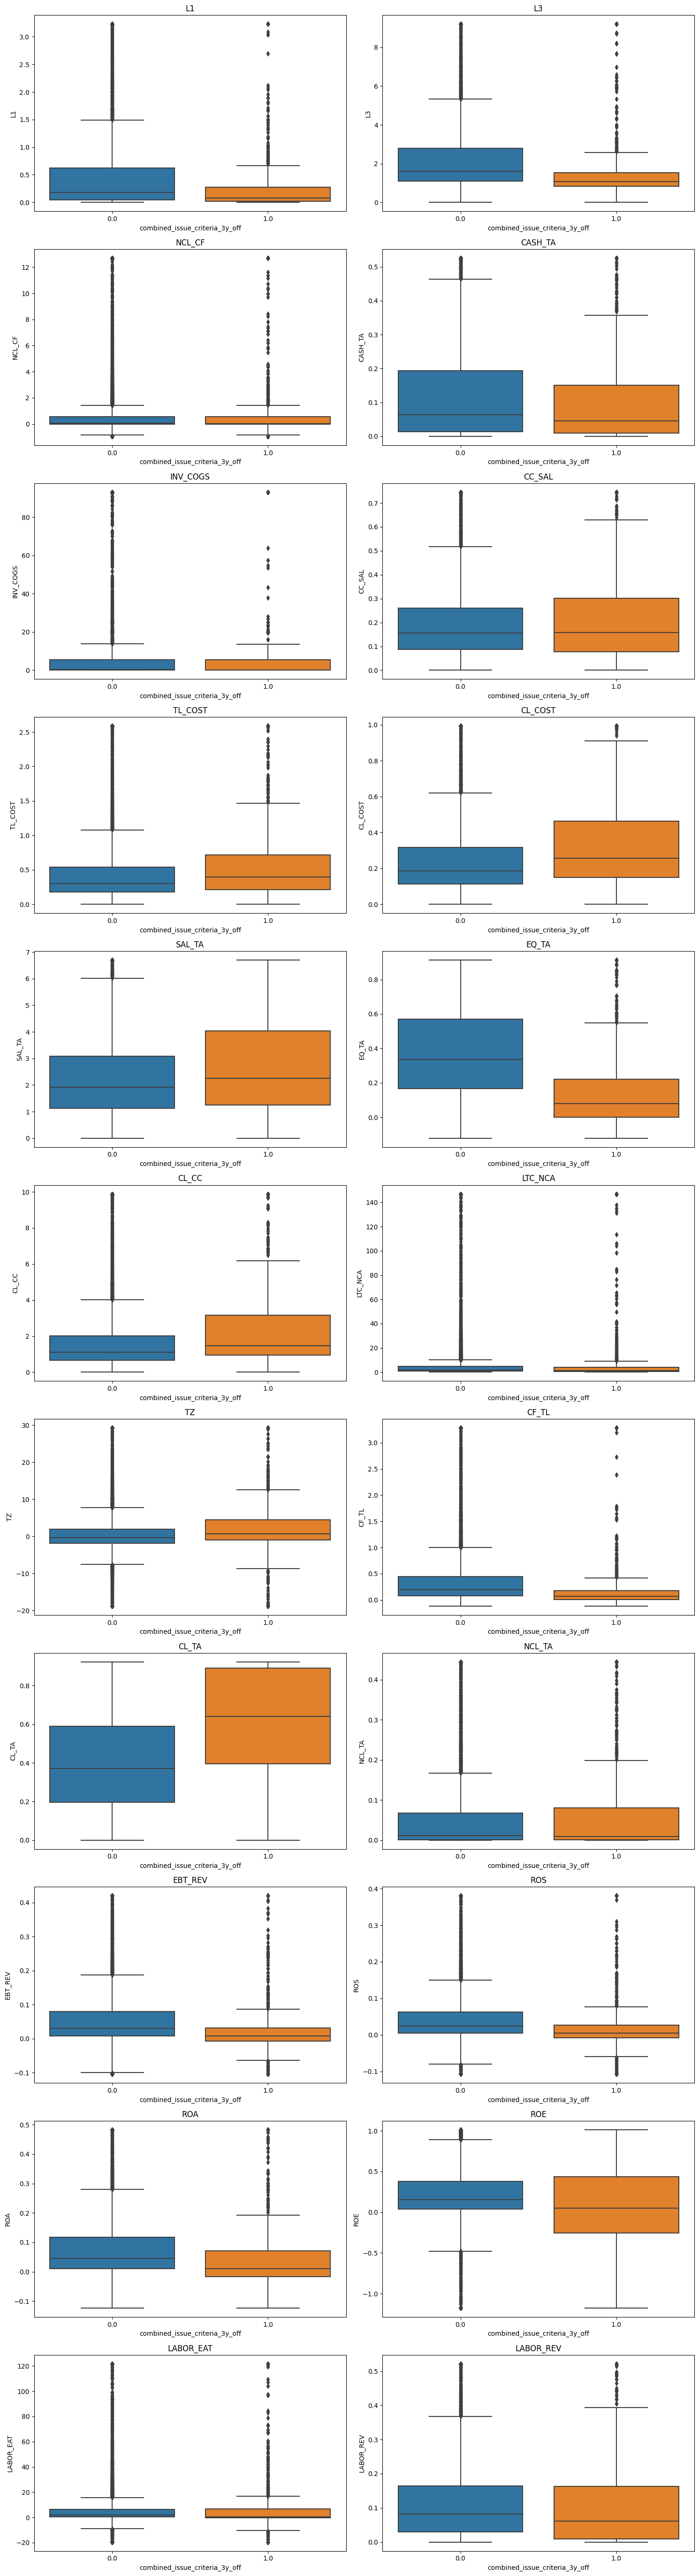

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your dataframe and 'target' is your target variable
df = data_filled[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features + equal_pdf)

# List of features
features = df.columns.drop('combined_issue_criteria_3y_off')

# Number of features
num_features = len(features)

# Number of rows for subplots (2 columns of 11 subplots each)
n_rows = (num_features + 1) // 2

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    sns.boxplot(x='combined_issue_criteria_3y_off', y=feature, data=df, ax=axes[i])
    axes[i].set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# sns.pairplot(data_filled[RATIOS].drop(columns=correlated_features))
# plt.show()